In [76]:
#NORMALIZACJA ZMIENNYCH
import pandas as pd
import numpy as np
data=pd.read_csv('laloos.csv',sep=';',decimal=',')

npdata=np.array(data.iloc[:,1:],dtype='float64')
npdata
avg=npdata.mean(axis=0)
std=npdata.std(axis=0)
npdata.shape[1]

for i in range(npdata.shape[1]):
    npdata[:,i]=(npdata[:,i]-avg[i])/std[i]




array([[-0.72190546, -0.77159383, -1.70829637, ...,  2.55189643,
        -1.78749485, -2.02538729],
       [-0.78480529, -0.85255781, -1.73964448, ...,  2.55189643,
        -1.78749485, -2.02538729],
       [-0.81202556, -0.79392269, -1.74370379, ...,  2.55189643,
        -1.78749485, -2.02538729],
       ...,
       [ 0.61076355,  0.67194345,  0.20386628, ..., -2.21251382,
         1.34187187, -0.15444931],
       [ 0.35551268,  0.50718743,  0.17486161, ..., -2.21251382,
         1.34187187, -0.15444931],
       [ 0.35496789,  0.31819978,  0.23499699, ..., -2.01119931,
         3.18819871,  2.64040729]])

C:\Users\dom\AppData\Local\Temp\ipykernel_14320\3434319809.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Data']=pd.to_datetime(data1['Data'])


                         Srednia  Ilosc
Znak stopy procentowej                 
-1                     -0.023085    118
 0                      0.000000    112
 1                      0.020192    130
--------------------------------------------------------------------------------
Srednie dla poniedzialek oraz dla wtorek sa rowne
Srednie dla poniedzialek oraz dla sroda sa rowne
Srednie dla poniedzialek oraz dla czwartek sa rowne
Srednie dla poniedzialek oraz dla piatek sa rowne
Srednie dla wtorek oraz dla sroda sa rowne
Srednie dla wtorek oraz dla czwartek sa rowne
Srednie dla wtorek oraz dla piatek sa rowne
Srednie dla sroda oraz dla czwartek sa rowne
Srednie dla sroda oraz dla piatek sa rowne
Srednie dla czwartek oraz dla piatek sa rowne
--------------------------------------------------------------------------------
Wariancje dla poniedzialek oraz dla wtorek sa rowne
Wariancje dla poniedzialek oraz dla sroda sa rowne
Wariancje dla poniedzialek oraz dla czwartek sa rowne
Wariancje dla

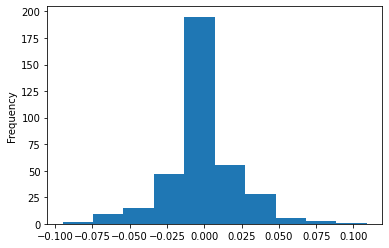

In [40]:
#Analiza gieldowa

import pandas as pd
import numpy as np
import matplotlib as mpl
import datetime
from os import listdir
from os.path import isfile, join
from datetime import timedelta
import scipy.stats
#Wczytaj dane
def ActionAnalysis(path):
    data=pd.read_csv(path,sep=',')
    data1=data[['Data','Najwyzszy','Zamkniecie']]
    data1['Data']=pd.to_datetime(data1['Data'])
    stopy=[0]
    dnitygodnia=[]
    miesiac=[]
    koniecmiesiaca=[]
    
    #UZUPEŁNIJ DANE O NIENOTOWANY WEEKEND
    ds=data1["Data"].iloc[0]
    dk=data1["Data"].iloc[-1]
    listofdates=pd.date_range(ds,dk-timedelta(days=1),freq='d').tolist()
    
    datafull=pd.DataFrame({'Data': listofdates})
    datafull = pd.merge(datafull, data1, how="left", on=["Data", "Data"])

    for i in range(len(datafull)):
        if pd.isnull(datafull.iloc[i,1]):
            datafull.iloc[i,1]=datafull.iloc[i-1,1]
            datafull.iloc[i,2]=datafull.iloc[i-1,2]

    #OKRESL DZIEN TYGODNIA
    for i in range(len(datafull)):
        dnitygodnia.append(datafull.iloc[i,0].weekday())
        dnitygodnia[i]+=1
        miesiac.append(datafull.iloc[i,0].month)
        
    #OKRESL CZY TO DANE NA KONIEC MIESIACA 
    for i in range(len(datafull)-1):
        if miesiac[i]!=miesiac[i+1]:
            koniecmiesiaca.append(1)
        else:
            koniecmiesiaca.append(0)
        stopy.append(round(np.log(datafull.iloc[i+1,2])-np.log(datafull.iloc[i,2]),3))
    koniecmiesiaca.append(0)
    
    #Dodaj nowe kolumny
    datafull['Stopy procentowe']=stopy
    datafull['Dzien tygodnia']=dnitygodnia
    datafull['Ostatni dzien miesiaca']=koniecmiesiaca

    #Oblicz stopy miesieczne
    danemiesieczne=datafull[datafull['Ostatni dzien miesiaca']==1]
    for i in range(len(danemiesieczne)-1):
        danemiesieczne.iloc[i+1,3]=(round(np.log(danemiesieczne.iloc[i+1,2])-np.log(danemiesieczne.iloc[i,2]),3))

    #Oblicz statystyki dla skumulowanych stóp procentowych
    pos = (datafull['Stopy procentowe']>0).sum()
    neg = (datafull['Stopy procentowe']<0).sum()
    neut=(datafull['Stopy procentowe'].count()-pos-neg)    
    mean = datafull['Stopy procentowe'].mean()
    std = datafull['Stopy procentowe'].std()
    skew=datafull['Stopy procentowe'].skew()
    quant1=datafull['Stopy procentowe'].quantile(q=0.25)
    median=datafull['Stopy procentowe'].quantile(q=0.5)
    median1=datafull['Stopy procentowe'].median()
    quant3=datafull['Stopy procentowe'].quantile(q=0.75)
    datafull['Stopy procentowe'].plot.hist(bins=10)

    #Znak stopy
    datafull['Znak stopy procentowej']=-1
    for i in range(len(datafull)):
        if datafull.iloc[i,3]>0:
            datafull.iloc[i,6]=1
        elif datafull.iloc[i,3]==0:
            datafull.iloc[i,6]=0
    
    dataX=datafull[['Stopy procentowe','Znak stopy procentowej']].groupby(['Znak stopy procentowej']).agg(Srednia=('Stopy procentowe','mean'),Ilosc=('Znak stopy procentowej','count'))
    print(dataX)
    print(80*'-')
    
    
    #Testy statystyczne - test roznic srednich dla danych dni tygodnia
    zlicz_dni=np.array(datafull.groupby(['Dzien tygodnia']).count().iloc[:5,0])
    danednitygodnia=datafull.groupby(['Dzien tygodnia']).mean().iloc[:5,2]
    danednitygodnia1=datafull.groupby(['Dzien tygodnia']).var().iloc[:5,2]
    stopywdniach=np.array(danednitygodnia)
    odchyleniawdniach=np.array(danednitygodnia1)
    slownikdni={1:'poniedzialek',2: 'wtorek',3:'sroda',4:'czwartek',5:'piatek'}
    for i in range(len(stopywdniach)):
        for j in range(len(stopywdniach)):
            if i<j:
                statystykatestowasrednie=(stopywdniach[i]-stopywdniach[j])/np.sqrt(odchyleniawdniach[i]/zlicz_dni[i]+odchyleniawdniach[j]/zlicz_dni[j])
                statystykakrytycznasrednie=scipy.stats.norm.ppf(0.975)
                if np.abs(statystykatestowasrednie)>statystykakrytycznasrednie:
                    print(f'Srednie dla {slownikdni[i+1]} oraz dla {slownikdni[j+1]} nie sa rowne')
                else:
                    print(f'Srednie dla {slownikdni[i+1]} oraz dla {slownikdni[j+1]} sa rowne')
    print(80*'-')
    #Testy statystyczne - test wariancji dla danych dni tygodnia
    for i in range(len(stopywdniach)):
        for j in range(len(stopywdniach)):
            if i<j:
                if odchyleniawdniach[i]>odchyleniawdniach[j]:
                    statystykatestowawariancja=odchyleniawdniach[i]/odchyleniawdniach[j]
                    statystykakrytycznawariancja=scipy.stats.f.ppf(1-0.05,dfn=zlicz_dni[i],dfd=zlicz_dni[j])
                else:
                    statystykatestowawariancja=odchyleniawdniach[j]/odchyleniawdniach[i]
                    statystykakrytycznawariancja=scipy.stats.f.ppf(1-0.05,dfn=zlicz_dni[j],dfd=zlicz_dni[i])
                if np.abs(statystykatestowawariancja)>statystykakrytycznawariancja:
                    print(f'Wariancje dla {slownikdni[i+1]} oraz dla {slownikdni[j+1]} nie sa rowne')
                else:
                    print(f'Wariancje dla {slownikdni[i+1]} oraz dla {slownikdni[j+1]} sa rowne')
    print(80*'-')           


    
    
    
    #Wyswietlanie informacji   
    print("Ile dodatnich:",pos)
    print("Ile ujemnych:",neg)
    print("Srednia:",mean)
    print("Mediana:",median)
    print("1 kwartyl:",quant1)
    print("3 kwartyl:",quant3)
    print("Skosnosc:",skew)
    print(80*'-')
    
    print("Srednia w kolejnych dniach tygodnia")
    print(datafull[['Dzien tygodnia','Stopy procentowe']].groupby(['Dzien tygodnia']).agg(Srednia=('Stopy procentowe','mean'),Ilosc=('Stopy procentowe','count'),Wariancja=('Stopy procentowe','var')))
    
    
    print(80*'-')
    print("DANE MIESIECZNE:")
    print(danemiesieczne[['Data','Zamkniecie','Stopy procentowe']])
    print("Srednia stopa miesieczna:",danemiesieczne['Stopy procentowe'].mean())
    
    
    
onlyfiles = [f for f in listdir("C:/Users/dom/Gielda") if isfile(join("C:/Users/dom/Gielda", f))]

for i in range(len(onlyfiles)):
    ActionAnalysis("C:/Users/dom/Gielda/"+str(onlyfiles[i]))



    

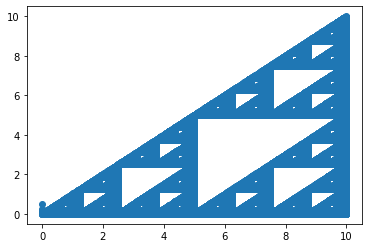